In [1]:

# Requirements: Matplotlib, Numpy, functions_util.py, index.py#, fitting_functions_ZNE.py, h5py

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
#print(os.getcwd())
from util.index import print_index, get_experiment, index_folder
from util.functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from util.fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE


def fit(function, x_axis, y_axis, return_cov=False, p0=[.05,2000000], weights=None):
    # Fit the data to the function
    popt, pcov = curve_fit(function, x_axis, y_axis, p0=p0, sigma=weights, absolute_sigma=True, maxfev=10000)
    
    if return_cov:
        return popt, pcov
    return popt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from util.h5analysis import *
from util.qsim_functions import*


In [3]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter

def find_peaks_in_data(data, height):
    peaks, _ = find_peaks(data, height=height)
    return peaks


def find_peaks_smooth(data, height, window_length, polyorder):
    # Apply Savitzky-Golay filter to smooth data
    smoothed_data = savgol_filter(data, window_length, polyorder)
    
    # Find peaks in smoothed data
    peaks, _ = find_peaks(smoothed_data, height=height)
    peak_values = smoothed_data[peaks]
    peaks = peaks[np.argmax(peak_values)]
    return peaks, smoothed_data[peaks]


In [4]:

#pairs = [(11,12), (12,13),(13,14)]
#bases = ['x', 'y', 'z']
#pairs_names = [265, 259, 266]
# basis_names = [268, 271, 269]
# foldername = 'Population_4_tw0'
# pairs_names = [str(name) for name in pairs_names]
# qubits = [11,12,13,14]
# shots = 150


#For Bz = 4
# phases = np.array([ 1, 2, 3, 4, 5, 6])*np.pi/6
# phase_names = [572, 573, 574, 575, 576, 577]
# phases_pop = np.array([0])*np.pi/6
# pop_name = [571]
# foldername = '15_chain_4_qubit_B=4'
# shots_pop = 200
#Angle should be 


'''comparing B = 6 and B = 4 for 15 chain, seeing the increase in noise as B increases'''
# phases = np.array([0,1, 2, 3, 4, 5, 6])*np.pi/6
# phase_names = [562,563, 564, 567, 568, 569, 570]
# phases_pop = np.array([0])*np.pi/6
# pop_name = [562]
# shots_pop = 600
# foldername = '15_chain_4_qubit_B=6'
# qubits = [2,3,4,5]
# #shots = 600
# shots = 200
# time_steps = 21
# prefix = '000572'
# B = 4
# evolution_time = 2.593
# angle_prediction = (B * evolution_time * 2) % (2 * np.pi)
# angle_pred_180 = (angle_prediction + np.pi)% (2 * np.pi)
# pop_prediction = (angle_prediction - np.pi/2)% (2 * np.pi)

"""Checking 45kHz detuning -- cross check with the Jij data"""
# phases = np.array([0,1, 2, 3, 4, 5, 6])*np.pi/6
# phase_names = ['091','092', '093', '094', '095', '096', '097']
# phases_pop = np.array([0])*np.pi/6
# pop_name = ['091']
# shots_pop = 150
# foldername = '45kHz_detune_shadow_check_parity_B4'
# qubits = [2,3,4,5]
# #shots = 600
# B = 4
# shots = 150
# time_steps = 21
# prefix = '000575'
# evolution_time = 2.593
# angle_prediction = (B * evolution_time * 2) % (2 * np.pi)
# angle_pred_180 = (angle_prediction + np.pi)% (2 * np.pi)
# pop_prediction = (angle_prediction - np.pi/2)% (2 * np.pi)
# print('expectation for angle prediction:', angle_prediction)

# """Checking 47kHz detuning -- cross check with the Jij data"""
# phases = np.array([0,1, 2, 3, 4, 5, 6])*np.pi/6
# phase_names = [ '084','085', '086', '087', '088', '089', '090']
# phases_pop = np.array([0])*np.pi/6
# pop_name = ['084']
# shots_pop = 150
# foldername = '47kHz_detune_shadow_check_parity_15'
# qubits = [2,3,4,5]
# #shots = 600
# B = 4
# shots = 150
# time_steps = 21
# prefix = '000575'
# evolution_time = 2.593
# angle_prediction = (B * evolution_time * 2) % (2 * np.pi)
# angle_pred_180 = (angle_prediction + np.pi)% (2 * np.pi)
# pop_prediction = (angle_prediction - np.pi/2)% (2 * np.pi)
# print('expectation for angle prediction:', angle_prediction)

# ##Checking 43 kHz detuning, should be bad
phases = np.array([0,1, 2, 3, 4, 5, 6])*np.pi/6
phase_names = [178, 179, 180, 181, 182, 183, 184]
phases_pop = np.array([0])*np.pi/6
pop_name = ['178']
shots_pop = 150
foldername = '43kHz_detune_shadow_check'
qubits = [2,3,4,5]
#shots = 600
B = 4
shots = 150
time_steps = 21
prefix = '000575'
evolution_time = 2.593
angle_prediction = (B * evolution_time * 2) % (2 * np.pi)
angle_pred_180 = (angle_prediction + np.pi)% (2 * np.pi)
pop_prediction = (angle_prediction - np.pi/2)% (2 * np.pi)
print('expectation for angle prediction:', angle_prediction)


# for name_index in range(len(pairs_names)):
#     name = pairs_names[name_index]
#     if '000563' in pairs_names:
#         pass
#     else:
#         name = '000563' + name
#         pairs_names[name_index] = name
phase_names = [str(name) for name in phase_names]
for name_index in range(len(phase_names)):
    name = phase_names[name_index]
    if prefix in phase_names:
        pass
    else:
        name = prefix + name
        phase_names[name_index] = name
        
pop_name = [str(name) for name in pop_name]
for name_index in range(len(pop_name)):
    name = pop_name[name_index]
    if prefix in pop_name:
        pass
    else:
        name = prefix + name
        pop_name[name_index] = name
full_data_folder_path = './data/' + foldername + '/'


expectation for angle prediction: 1.894444078461241


In [5]:
COUNTS_THRESHOLD = 1


In [6]:
measurement_data = np.zeros((time_steps, len(phase_names)), dtype=dict)
#flopping_matrix = np.zeros((30, len(pairs_names)))
#flopping_std_matrix = np.zeros((30, len(pairs_names)))
#times = None

expectations_matrix = np.zeros((time_steps,len(phase_names)))
qubit_0_magnetization = np.zeros((time_steps,len(phase_names)))
leakage_factor = np.zeros((time_steps,len(phase_names)))

print(os.getcwd())
for file_id_index in range(len(phase_names)):
    
    file_id = phase_names[file_id_index]
    phase = phases[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    if file_id_index == 0:
        times_start = times
    if file_id_index == 3:
        times_end = times
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts[:,0,0])
    #print(counts.shape)
    measurements = np.zeros((len(qubits), shots, time_steps))
    for qubit_index in range(len(qubits)):
        qubit = qubits[qubit_index]
        #qubit = pair[pair_index]
        measurements[qubit_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, time_steps), dtype='<U5')
    for i in range(shots):
        for j in range(time_steps):
            bitstring = [str(int(measurements[qubit_index,i,j])) for qubit_index in range(len(qubits))]
            bitstring = "".join(bitstring)
            counts_bitstrings[i,j] = bitstring
    counts_dicts = np.zeros(time_steps, dtype=dict)
    for j in range(time_steps):
        magnetization = 0
        for shot_index in range(shots):
            magnetization += measurements[0, shot_index, j]*2 - 1
        qubit_0_magnetization[j,file_id_index] = magnetization/shots
        temp_dict = {}#
        #{'0000':0, '1111':0}
        for i in range(shots):
            if counts_bitstrings[i,j] in temp_dict:
                temp_dict[counts_bitstrings[i,j]] += 1/shots
            else:
                temp_dict[counts_bitstrings[i,j]] = 1/shots
        counts_dicts[j] = temp_dict
        expectation = 0
        for key in temp_dict.keys():
            #count the number of zeros. If it is even, add the value. If it is odd, subtract the value
            num_zeros = key.count('0')
            if num_zeros % 2 == 0:
                expectation += temp_dict[key]
            else:
                expectation -= temp_dict[key]
        expectations_matrix[j,file_id_index] = expectation
        print(expectation)
    measurement_data[:,file_id_index] = counts_dicts
    
    

    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.3066666666666664
0.546666666666666
0.3999999999999993
0.49333333333333285
0.4399999999999996
0.34666666666666623
0.3333333333333329
0.22666666666666627
0.17333333333333312
0.07999999999999978
-0.013333333333333473
-9.020562075079397e-17
0.026666666666666575
0.03999999999999989
0.05333333333333315
0.10666666666666641
0.11999999999999977
0.09333333333333313
0.19999999999999968
0.10666666666666635
0.19999999999999965
[ 0.  0. 13. 10. 15. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0.23999999999999957
0.30666666666666614
0.14666666666666625
0.43999999999999945
0.18666666666666615
0.2666666666666663
0.13333333333333294
0.1066666666666663
-0.05333333333333351
-0.25333333333333335
-0.1333333333333335
-0.32000000000000006
-0.13333333333333336
-0.1333333333333333
-0.24000000000000007
-0.1333333333333334
0.026666666666666686
-0.11999999999999998
0.013333333333333232
0.31999999999999984
0.26666666666666655
[

In [7]:
#Good keys are keys which are hamming distance 1 away from 0000 or 1111
all_good_keys = ['0000', '1111', '0001', '0010', '0100', '1000', '1110', '1101', '1011', '0111']
all_good_keys=['0000','1111']

In [8]:
measurement_data_pop = np.zeros((time_steps, len(pop_name)), dtype=dict)
#flopping_matrix = np.zeros((30, len(pairs_names)))
#flopping_std_matrix = np.zeros((30, len(pairs_names)))
#times = None

expectations_matrix_pop = np.zeros((time_steps,len(pop_name)))
expectation_ZZZZ_pop = np.zeros((time_steps,len(pop_name)))
qubit_0_magnetization_pop = np.zeros((time_steps,len(pop_name)))
leakage_factor_pop = np.zeros((time_steps,len(pop_name)))

print(os.getcwd())
for file_id_index in range(len(pop_name)):
    
    file_id = pop_name[file_id_index]
    phase = phases_pop[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    if file_id_index == 0:
        times_start = times
    if file_id_index == 3:
        times_end = times
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((len(qubits), shots_pop, time_steps))
    for qubit_index in range(len(qubits)):
        qubit = qubits[qubit_index]
        #qubit = pair[pair_index]
        measurements[qubit_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots_pop, time_steps), dtype='<U5')
    for i in range(shots_pop):
        for j in range(time_steps):
            bitstring = [str(int(measurements[qubit_index,i,j])) for qubit_index in range(len(qubits))]
            bitstring = "".join(bitstring)
            counts_bitstrings[i,j] = bitstring
    counts_dicts = np.zeros(time_steps, dtype=dict)
    for j in range(time_steps):
        magnetization = 0
        for shot_index in range(shots_pop):
            magnetization += measurements[0, shot_index, j]*2 - 1
        qubit_0_magnetization_pop[j,file_id_index] = magnetization/shots_pop
        temp_dict = {}#
        #{'0000':0, '1111':0}
        for i in range(shots_pop):
            if counts_bitstrings[i,j] in temp_dict:
                temp_dict[counts_bitstrings[i,j]] += 1/shots_pop
            else:
                temp_dict[counts_bitstrings[i,j]] = 1/shots_pop
        counts_dicts[j] = temp_dict
        expectation = 0
        expectation_ZZZZ = 0
        print('---')
        for key in temp_dict.keys():
            print(key, temp_dict[key])
            if key in all_good_keys:
                expectation += temp_dict[key]
                
            count_zero = key.count('0')
            if count_zero % 2 == 0:
                expectation_ZZZZ += temp_dict[key]
            else:
                expectation_ZZZZ -= temp_dict[key]
        expectation_ZZZZ_pop[j,file_id_index] = expectation_ZZZZ

        expectations_matrix_pop[j,file_id_index] = expectation
        #print(expectation)
    measurement_data_pop[:,file_id_index] = counts_dicts
    
    

    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
(15, 150, 21)
---
0000 0.26666666666666644
0100 0.060000000000000005
1110 0.08666666666666667
1111 0.1666666666666666
1101 0.04666666666666667
1100 0.060000000000000005
0001 0.04666666666666667
1000 0.02
0010 0.013333333333333334
0101 0.02666666666666667
1011 0.013333333333333334
0011 0.07333333333333333
1010 0.006666666666666667
1001 0.03333333333333333
0111 0.060000000000000005
0110 0.02
---
0111 0.06666666666666667
1110 0.04
1111 0.333333333333333
1001 0.03333333333333333
0110 0.02666666666666667
0000 0.27999999999999975
0010 0.006666666666666667
1011 0.04
1000 0.02666666666666667
0011 0.02
1010 0.013333333333333334
1100 0.04666666666666667
1101 0.02
0100 0.013333333333333334
0001 0.013333333333333334
0101 0.02
---
1010 0.02666666666666667
0000 0.23333333333333314
1100 0.04
1111 0.2999999999999997
1110 0.03333333333333333
0001 0.04
0011 0.05333333333333334
0010 0.04666666666666667
0110 0.02666666666666667
1101 0.05333333333333334
0111 0.07

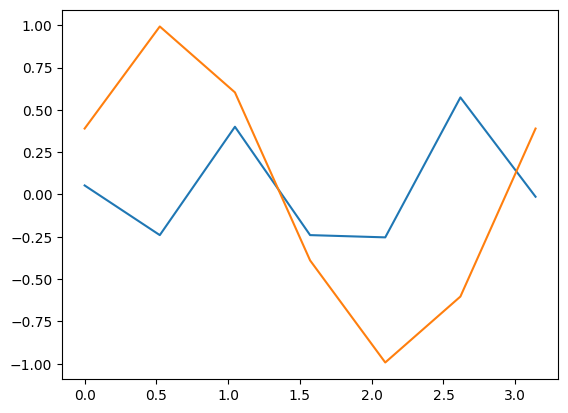

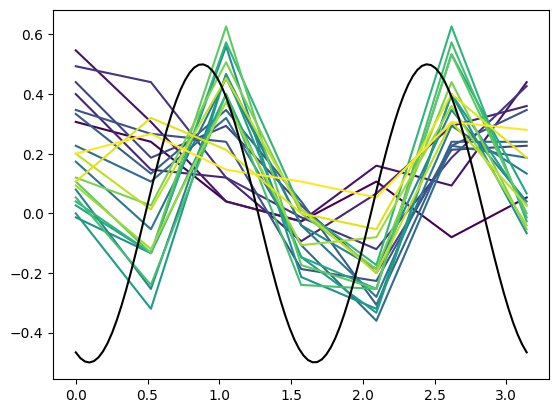

In [9]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(time_steps):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
phases_dense = np.linspace(0, np.pi, 100)
ax.plot(phases_dense, -0.5*np.sin(4*np.array(phases_dense)+1.2 ), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
#plt.legend()

[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.14285714  3.42857143
  1.71428571]
3.428571428571429
[-0.         -1.71428571 -3.42857143 -5.14285714  5.142

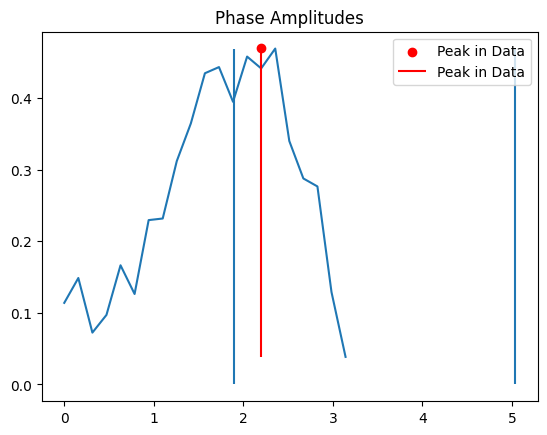

In [10]:
amps = np.zeros(time_steps)
for i in range(time_steps):
    test = data_matrix[i,:]
    fft_test = np.fft.fft(test)*2/len(test)
    frequencies = np.fft.fftfreq(len(test), phases[0]-phases[1])*2*np.pi
    #print(frequencies)
    print(frequencies)
    good_index = np.argmin(np.abs(frequencies - len(qubits)))
    print(frequencies[good_index])
    amp_4 = np.abs(fft_test[good_index])
    amps[i] = amp_4
amps_fit = np.zeros(time_steps)
def sin_fit(x, a, b,c):
    return np.sin(4*x + c)*a + b

for i in range(time_steps):
    test = data_matrix[i,:]
    popt, pcov = curve_fit(sin_fit, phases, test, p0=[0.5,0,0])
    amps_fit[i] = abs(popt[0])

amps = amps_fit
times
plt.plot(times, amps)
#plt.plot(range(time_steps), amps_fit)
#return the index of the maximum amplitude

plt.vlines(angle_prediction, 0, max(amps))
plt.vlines(angle_pred_180, 0, max(amps))

plt.title('Phase Amplitudes')


print(find_peaks_smooth(amps, np.average(amps), 5,2))
peaks, smoothed = find_peaks_smooth(amps, np.average(amps), 5, 2)
print(times[peaks])
print(amps[peaks])



max_amp = smoothed
print(max_amp)
max_angle = times[peaks]
#print(max_angle)
plt.scatter(max_angle, max_amp, color='red', label='Peak in Data')
plt.vlines(max_angle, min(amps), max_amp, colors='red', label='Peak in Data')

plt.legend()
plt.savefig('data/' + foldername + '/amplitude_vs_angle.png')



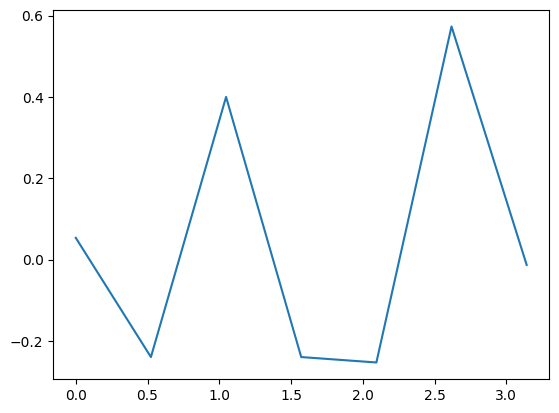

In [11]:
plt.plot(phases, data_matrix[peaks,:])



In [12]:
# data_matrix = np.zeros((time_steps, len(phase_names)))
# for i in range(len(phase_names)):
#     data_matrix[:,i] = expectations_matrix[:,i]
# plt.plot(phases, data_matrix[14,:])
# plt.plot(phases, np.sin(2*np.array(phases)+0.4))
# #Plot each index int he time step using a different color from a color bar
# fig, ax = plt.subplots()
# colors = cm.viridis(np.linspace(0, 1, time_steps))
# for i in range(15,time_steps):
#     ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
# phases_dense = np.linspace(np.pi/6, np.pi, 100)
# ax.plot(phases_dense, -0.5*np.sin(4*np.array(phases_dense)+1.2 ), color='black', label='Sin fit')
# #cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
# plt.legend()
# plt.show()

# fig, ax = plt.subplots()
# colors = cm.viridis(np.linspace(0, 1, time_steps))
# for i in range(4,10):
#     ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
# phases_dense = np.linspace(np.pi/6, np.pi, 100)
# ax.plot(phases_dense, 0.5*np.sin(4*np.array(phases_dense)+1 ), color='black', label='Sin fit')
# #cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
# plt.legend()
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
0.15707963267948966
0.6133333333333327
(3, 0.5606349206349206)
0.47123889803846897
0.5599999999999995
0.5606349206349206


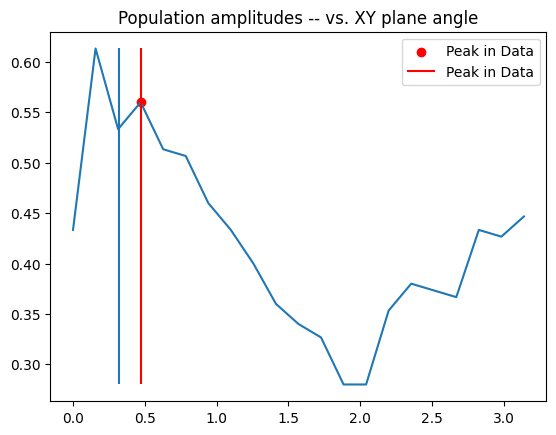

In [13]:

#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()

ax.plot(times, expectations_matrix_pop[:,0])

#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()
#Get the index of the peak:
peak_index = np.argmax(expectations_matrix_pop[:-17,0])
print(peak_index)
print(times[peak_index])
print(expectations_matrix_pop[peak_index,0])


print(find_peaks_smooth(expectations_matrix_pop[:,0], np.average(expectations_matrix_pop[:,0]), 7,2))
peaks, smoothed = find_peaks_smooth(expectations_matrix_pop[:,0], np.average(expectations_matrix_pop[:,0]), 7, 2)
print(times[peaks])
print(expectations_matrix_pop[:,0][peaks])

max_pop = smoothed
print(max_pop)
max_angle_pop = times[peaks]
#print(max_angle)
plt.scatter(max_angle_pop, max_pop, color='red', label='Peak in Data')
plt.vlines(max_angle_pop, min(expectations_matrix_pop[:,0]), max(expectations_matrix_pop[:,0]), colors='red', label='Peak in Data')

plt.legend()
plt.title('Population amplitudes -- vs. XY plane angle')
plt.vlines(pop_prediction, min(expectations_matrix_pop[:,0]), max(expectations_matrix_pop[:,0]))


plt.savefig('data/' + foldername + '/population_vs_angle.png')

In [14]:
print((max_pop+ max_amp)/2)
print('Max Pop, Amp:', max_pop, max_amp)
print('Population angle:', max_angle_pop)
print('Amplitude angle:', max_angle)
print('Difference :',( max_angle_pop - max_angle))
#Save

0.514895611201666
Max Pop, Amp: 0.5606349206349206 0.4691563017684115
Population angle: 0.47123889803846897
Amplitude angle: 2.199114857512855
Difference : -1.7278759594743862


IndexError: index 30 is out of bounds for axis 0 with size 21

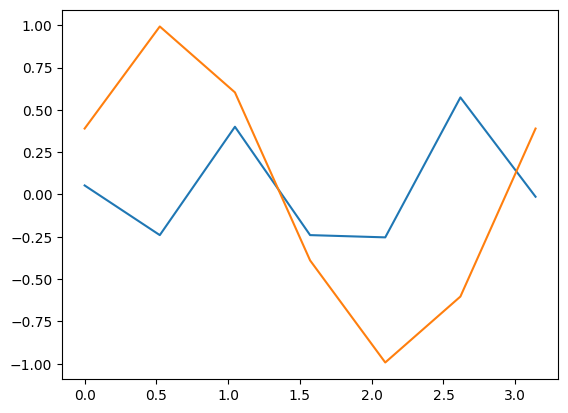

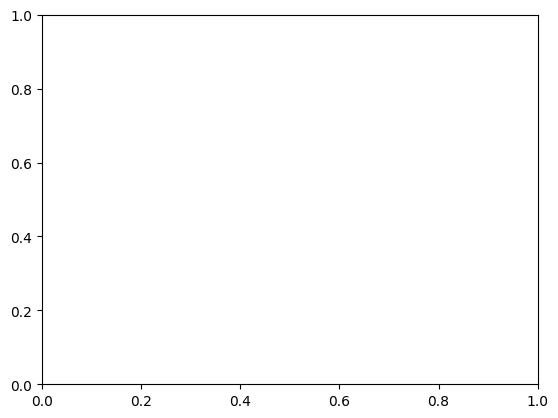

In [15]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(30,34):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
ax.plot(phases, 0.8*np.sin(2*np.array(phases)+0.6), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()

In [ ]:
x_axis = [val for val in x_vals]

ValueError: x and y must be the same size

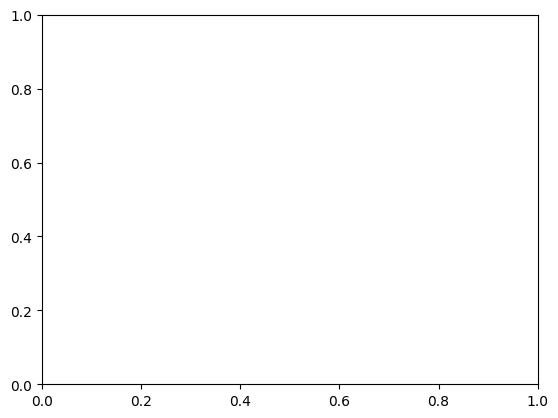

In [ ]:
plt.scatter(phases, expectations_matrix[:,0])
#Fit each of the axies to a sign function:

plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))

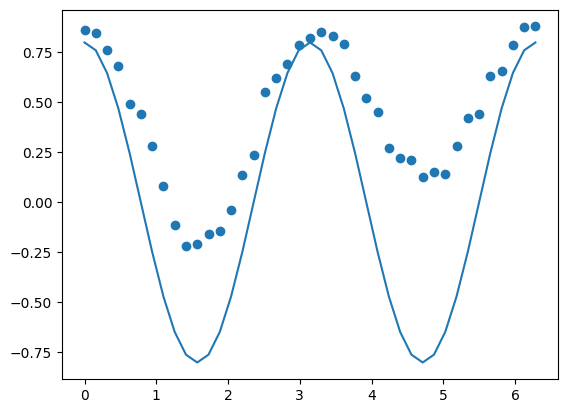

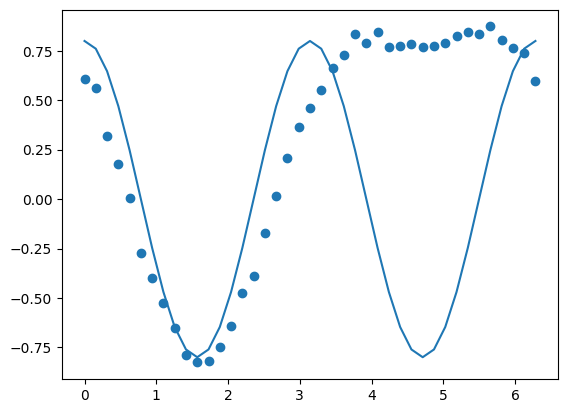

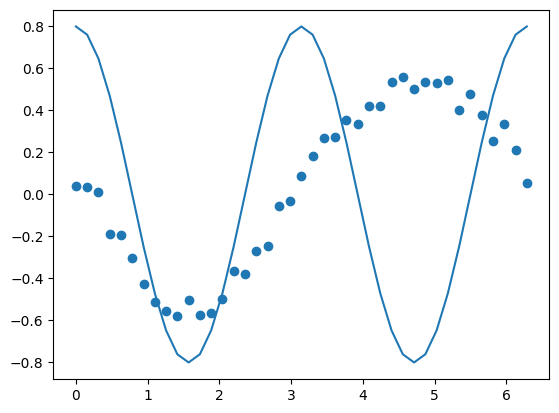

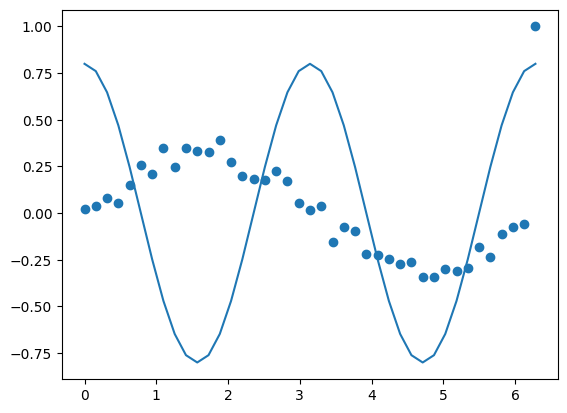

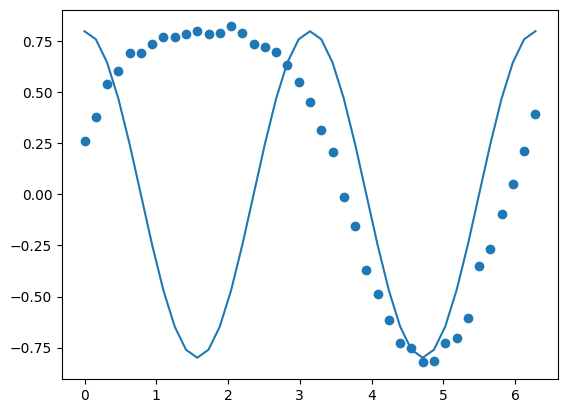

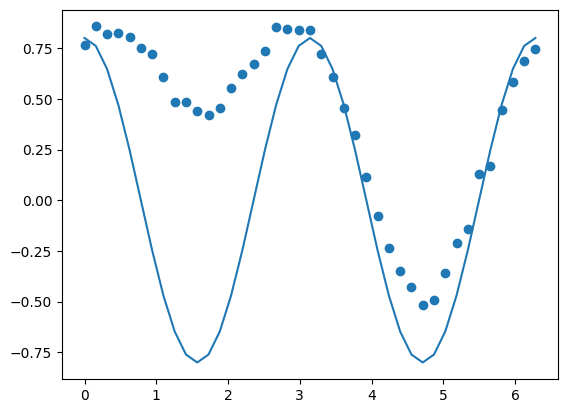

In [ ]:
for i in range(6):
    

    plt.scatter(x_axis, expectations_matrix[:,i])
    #Fit each of the axies to a sign function:

    plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))
    plt.show()

In [ ]:
print(expectations_matrix)

[[ 0.83]
 [ 0.82]
 [ 0.58]
 [ 0.49]
 [ 0.01]
 [ 0.14]
 [-0.12]
 [-0.15]
 [-0.57]
 [-0.57]
 [-0.53]
 [-0.56]
 [-0.43]
 [-0.34]
 [-0.08]
 [ 0.08]
 [ 0.23]
 [ 0.41]
 [ 0.47]
 [ 0.65]
 [ 0.82]
 [ 0.8 ]
 [ 0.92]
 [ 0.9 ]
 [ 0.8 ]
 [ 0.82]
 [ 0.62]
 [ 0.6 ]
 [ 0.6 ]
 [ 0.53]
 [ 0.48]
 [ 0.6 ]
 [ 0.56]
 [ 0.65]
 [ 0.57]
 [ 0.78]
 [ 0.87]
 [ 0.9 ]
 [ 0.85]
 [ 0.77]
 [ 0.8 ]]


TypeError: Improper input: func input vector length N=4 must not exceed func output vector length M=1

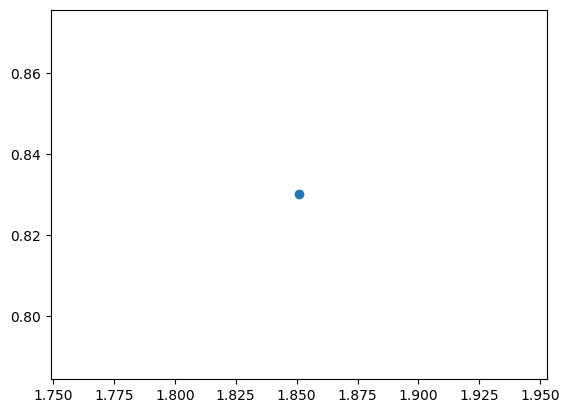

In [ ]:
plt.scatter(phases, expectations_matrix[0,:])
#Fit to a sin function:
def sine(x, A, B, C, D):
    return A*np.sin(B*x + C) + D
phases_sorted = phases.copy()
phases_dense = np.linspace(0, 1.25*np.pi, 1000)
phases_sorted.sort()
popt, pcov = fit(sine, phases, expectations_matrix[0,:], return_cov=True, p0=[.5, 2, 0, 0])
plt.plot(phases_dense, sine(phases_dense, *popt))
print(popt[0])
